<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>15 de julio 2022</b><br/>

# 1. Cargando librerías

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Cargando set de datos

In [306]:
xls = pd.ExcelFile('estaturas.xlsx')
normales = pd.read_excel(xls, 'normales')
valtest_normales = pd.read_excel(xls, 'valtest(normales)')
valtest_anomalias = pd.read_excel(xls, 'valtest(anomalias)')

Renombrando columnas

In [307]:
normales = pd.DataFrame({"altura": normales.iloc[:,0], "edad": normales.iloc[:,1]})
valtest_normales = pd.DataFrame({"altura": valtest_normales.iloc[:,0], "edad": valtest_normales.iloc[:,1]})
valtest_anomalias = pd.DataFrame({"altura": valtest_anomalias.iloc[:,0], "edad": valtest_anomalias.iloc[:,1]})

Normalización

In [308]:
altura_mean = normales.altura.mean(axis=0)
altura_std = normales.altura.std(axis=0)
edad_mean = normales.edad.mean(axis=0)
edad_std = normales.edad.std(axis=0)

In [309]:
normales_n = normales.copy()
normales_n.altura = (normales.altura-altura_mean)/altura_std
normales_n.edad = (normales.edad-edad_mean)/edad_std

valtest_normales_n = valtest_normales.copy()
valtest_normales_n.altura = (valtest_normales.altura-altura_mean)/altura_std
valtest_normales_n.edad = (valtest_normales.edad-edad_mean)/edad_std

valtest_anomalias_n = valtest_anomalias.copy()
valtest_anomalias_n.altura = (valtest_anomalias.altura-altura_mean)/altura_std
valtest_anomalias_n.edad = (valtest_anomalias.edad-edad_mean)/edad_std

# 3. Algoritmo K-Means

In [310]:
#Indices aleatorios
np.random.seed(2022)

In [311]:
#Algoritmo recursivo
def k_means(k_mean_param, k_mean_set, kparams, contador, ciclo):
    posicion_kparams = kparams.copy()
    longitud = len(k_mean_set)
    #Creando array de distancias y asignación de clusters
    distancias = np.full(longitud, -1.0)
    cluster = np.zeros(longitud)
    #Para cada registro
    for i in range(longitud):
        i_edad = k_mean_set.iloc[i,:].edad
        i_altura = k_mean_set.iloc[i,:].altura
        #Encontrando el centroide más cercano
        for j in range(k_mean_param):
            k_edad = kparams.iloc[j,:].edad
            k_altura = kparams.iloc[j,:].altura
            #Distancia
            distance_k = np.sqrt((k_edad - i_edad) ** 2 + (k_altura - i_altura) ** 2)
            if( distancias[i]==-1 or distancias[i]>distance_k):
                #Distancia más corta
                distancias[i] = distance_k
                cluster[i] = j
    #Reasignando posición de los clusters
    for j in range(k_mean_param):
        kparams.iloc[j,:].edad = k_mean_set["edad"][cluster == j].mean(axis=0)
        kparams.iloc[j,:].altura = k_mean_set["altura"][cluster == j].mean(axis=0)
    #Incrementar el contador si la posición de los clusters es la misma
    if( posicion_kparams.equals(kparams) ):
        contador=contador+1
    #Si la posición de los clusters es la misma dos veces consecutivamente
    if( contador >= 2):
        #Regresar parametros
        return (cluster, kparams, ciclo)
    else:
        #Repetir algoritmo
        return k_means(k_mean_param, k_mean_set, kparams, contador, ciclo + 1)

In [312]:
#Algoritmo kmeans
def k_means_algoritmo(k_mean_param, k_mean_set):
    #Calculando posición de clusters aleatoria
    longitud = len(k_mean_set)
    indices = np.random.choice(longitud, k_mean_param, replace=False)
    kparams = k_mean_set.iloc[indices,:].copy()
    return k_means(k_mean_param, k_mean_set, kparams, 0, 1)

Ejecutando algoritmo K-means recursivo:

In [313]:
(cluster, kparams, ciclos) = k_means_algoritmo(3, normales_n)

In [314]:
print("El algoritmo se ejecutó",ciclos,"veces después de 2 iteraciones en el mismo lugar.")

El algoritmo se ejecutó 5 veces después de 2 iteraciones en el mismo lugar.


Clusters encontrados:

In [315]:
kparams.altura = (kparams.altura * altura_std) + altura_mean
kparams.edad = (kparams.edad * edad_std) + edad_mean
print(kparams.reset_index(drop=True))

     altura       edad
0  1.670769  30.692308
1  1.774000  25.450000
2  1.816000  42.800000


Tabla de edades y cluster asignado:

In [316]:
normales_kmeans = normales.copy()
normales_kmeans["cluster"] = cluster
normales_kmeans["cluster_altura"] = np.array(kparams.iloc[cluster,:].altura)
normales_kmeans["cluster_edad"] = np.array(kparams.iloc[cluster,:].edad)
normales_kmeans.head()

,altura,edad,cluster,cluster_altura,cluster_edad
0,1.77,26,1.0,1.774000,25.450000
1,1.74,31,0.0,1.670769,30.692308
2,1.72,24,1.0,1.774000,25.450000
3,1.78,34,1.0,1.774000,25.450000
4,1.65,32,0.0,1.670769,30.692308


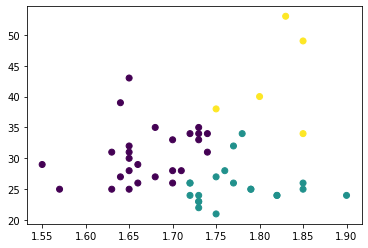

In [317]:
plt.scatter(normales_kmeans.altura, normales_kmeans.edad, alpha=1, c=normales_kmeans.cluster)